In [1]:
import torch
#import tensorflow
import numpy as np 
import matplotlib.pyplot as plt
#import predictive_imputer
import pandas as pd

In [12]:
#ACCORDING TO DOCUMENTATION OF PREDICTIVE_IMPUTER MODULE (WHERE THE FOLLOWING CODE IS FROM)
#FOLLOWING RANDOM FOREST IMPUTATION METHOD IS EQUIVALENT TO MISSFOREST ALGORITHM IN R
#missforest is used in many scholarly articles
#missforest alg uses random forest iteratively

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.preprocessing import Imputer
from sklearn.utils.validation import check_array, check_is_fitted, check_X_y


class PredictiveImputer(BaseEstimator, TransformerMixin):
    def __init__(self, max_iter=10, initial_strategy='mean', tol=1e-3, f_model="RandomForest"):
        self.max_iter = max_iter
        self.initial_strategy = initial_strategy
        self.initial_imputer = Imputer(strategy=initial_strategy)
        self.tol = tol
        self.f_model = f_model

    def fit(self, X, y=None, **kwargs):
        X = check_array(X, dtype=np.float64, force_all_finite=False)

        X_nan = np.isnan(X)
        most_by_nan = X_nan.sum(axis=0).argsort()[::-1]

        imputed = self.initial_imputer.fit_transform(X)
        new_imputed = imputed.copy()

        self.statistics_ = np.ma.getdata(X)
        self.gamma_ = []

        if self.f_model == "RandomForest":
            self.estimators_ = [RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=i, **kwargs) for i in range(X.shape[1])]
        elif self.f_model == "KNN":
            self.estimators_ = [KNeighborsRegressor(n_neighbors=min(5, sum(~X_nan[:, i])), **kwargs) for i in range(X.shape[1])]
        elif self.f_model == "PCA":
            self.estimators_ = [PCA(n_components=int(np.sqrt(min(X.shape))), whiten=True, **kwargs)]

        for iter in range(self.max_iter):
            if len(self.estimators_) > 1:
                for i in most_by_nan:

                    X_s = np.delete(new_imputed, i, 1)
                    y_nan = X_nan[:, i]

                    X_train = X_s[~y_nan]
                    y_train = new_imputed[~y_nan, i]
                    X_unk = X_s[y_nan]

                    estimator_ = self.estimators_[i]
                    estimator_.fit(X_train, y_train)
                    if len(X_unk) > 0:
                        new_imputed[y_nan, i] = estimator_.predict(X_unk)

            else:
                estimator_ = self.estimators_[0]
                estimator_.fit(new_imputed)
                new_imputed[X_nan] = estimator_.inverse_transform(estimator_.transform(new_imputed))[X_nan]

            gamma = ((new_imputed-imputed)**2/(1e-6+new_imputed.var(axis=0))).sum()/(1e-6+X_nan.sum())
            self.gamma_.append(gamma)
            if np.abs(np.diff(self.gamma_[-2:])) < self.tol:
                break

        return self

    def transform(self, X):
        check_is_fitted(self, ['statistics_', 'estimators_', 'gamma_'])
        X = check_array(X, copy=True, dtype=np.float64, force_all_finite=False)
        if X.shape[1] != self.statistics_.shape[1]:
            raise ValueError("X has %d features per sample, expected %d"
                             % (X.shape[1], self.statistics_.shape[1]))

        X_nan = np.isnan(X)
        imputed = self.initial_imputer.transform(X)

        if len(self.estimators_) > 1:
            for i, estimator_ in enumerate(self.estimators_):
                X_s = np.delete(imputed, i, 1)
                y_nan = X_nan[:, i]

                X_unk = X_s[y_nan]
                if len(X_unk) > 0:
                    X[y_nan, i] = estimator_.predict(X_unk)

        else:
            estimator_ = self.estimators_[0]
            X[X_nan] = estimator_.inverse_transform(estimator_.transform(imputed))[X_nan]

        return X

In [13]:
#testing how random forest imputation works

X = np.asarray(
        [[None  , 200.0 , None  ],
         [   1.1, 100.4 ,    5.3],
         [   5.3, 100.5 ,    1.3],
         [None  , None  ,    1.9],
         [   1.2, 100.4 , None  ],
         [   2.3, 100.7 ,    2.4],
         [   1.6, None  ,    2.4],
         [None  , 100.8 , None  ]])

X = np.asarray(
        [[None  , 0.0 , None  ],
         [   0.1, 0.9 ,    0.3],
         [   0.7, 0.7 ,    0.3],
         [None  , None,    0.2],
         [   0.9, 0.8 , None  ],
         [   0.3, 0.7 ,    0.4],
         [   0.6, None,    0.4],
         [None  , 0.8 , None  ]])

#create object of this class
imputerObject= PredictiveImputer(f_model="RandomForest")

#call method of this object's class
transformer = imputerObject.fit(X=X)
#return transformed data
X_transformed = transformer.transform(X=X)

print(X_transformed)

C:\Users\klind\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)
C:\Users\klind\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


[[0.702 0.    0.3  ]
 [0.1   0.9   0.3  ]
 [0.7   0.7   0.3  ]
 [0.642 0.254 0.2  ]
 [0.9   0.8   0.304]
 [0.3   0.7   0.4  ]
 [0.6   0.734 0.4  ]
 [0.668 0.8   0.318]]


In [14]:
allTimeSeries=torch.load("data/192T/time_series.pt")
allMasks=torch.load("data/192T/masks.pt")
allDiffs=torch.load("data/192T/diffs.pt")
allLabels=torch.load("data/192T/labels.pt")

In [15]:
def calculateGlobalMean(variableNum, allTimeSeries, allDiffs):
    meanForPatientArray=[]
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS
    numOfPatients=1000
    
    for i in range(numOfPatients):
        timeSeriesForPatientAndVariable = np.asarray(allTimeSeries[i, ... , variableNum])
        diffForPatientAndVariable = np.asarray(allDiffs[i, ..., variableNum])
        if (diffForPatientAndVariable[191]>=3.9791667):
            #print('patient ', i, ' does not have any observations for variable ', variableNum)
            pass
        else:
            meanForPatient = np.mean(timeSeriesForPatientAndVariable, dtype ='float64')
            meanForPatientArray.append(meanForPatient)
    
    
    if(len(meanForPatientArray)<(.05*6261)):     #if there are too few observations for this variable
        globalMean = 0.0                        
        #impute with zero because healthy ppl are not tested for this variable
        print('imputed with zeros')
        #print('length for meanForPatientsArray: ', len(meanForPatientArray))
    else:
        globalMean = np.mean(meanForPatientArray, dtype ='float64')
    
    return globalMean

In [18]:
#IMPUTATION WITH MEAN OF ENTIRE TIME SEREIS

def impute_missforest(allTimeSeries, allMasks, allDiffs):
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS' TIME SERIES
    numOfPatients = 2
    
    #create object of this class
    imputerObject= PredictiveImputer(f_model="RandomForest")
    
    allTimeSeriesAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allMasksAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allDiffsAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))

    for i in range(1, numOfPatients):                         #6261 is num of patients
        
        perPatientTimeSeriesMatrix = np.zeros(shape=(192, 58))
        
        for j in range(59):                       #59 is num of variables
            
            if j==19:   
                #variable 19 (temperature) is unneccessray becuase it is same as variable 45 except it has more missing data
                pass
            
            else:
                oneTimeSeries = np.asarray(allTimeSeries[i, ..., j])
                oneMask = np.asarray(allMasks[i, ..., j])
                oneDiff = np.asarray(allDiffs[i, ..., j])
                print('patient num', i, 'variable number: ', j)
                realObservations = []                #vector with observed data values that are not outliers
                indexesOfRealObservations = []

                #fill up yVector with observed data values
                for k in range(192):
                    if (oneMask[k]==0.0):              #if datapoint is NOT originally missing
                        indexesOfRealObservations.append(k)
                        realObservations.append(oneTimeSeries[k])

                #calculating mean, standard deviation, bounds for outliers
                mean = np.mean(realObservations)
                sd = np.std(realObservations)
                upperBound = mean + 2*sd
                lowerBound = mean - 2*sd

                #finding outliers    
                indexesOfNoOutliersRealObservations = []
                noOutliersRealObservations = []
                for t in range(len(realObservations)):
                    indexesOfNoOutliersRealObservations.append(indexesOfRealObservations[t])
                    noOutliersRealObservations.append(realObservations[t])
                for m in range(len(realObservations)):
                    if (realObservations[m] > upperBound or realObservations[m] < lowerBound):
                        #print('outlier tick')
                        indexOfOutlierInOriginalTS = indexesOfRealObservations[m]
                        #print('outlier index in original TS: ', indexOfOutlierInOriginalTS)
                        indexesOfNoOutliersRealObservations.remove(indexOfOutlierInOriginalTS)
                        noOutliersRealObservations.remove(realObservations[m])
                    else:    #if this real observation is not an outlier
                        pass 
                
                #replacing time series outliers and missing values with None, masks with 1.0, diffs with 0.0 
                if len(indexesOfRealObservations)==0:
                    globalMean=calculateGlobalMean(j, allTimeSeries, allDiffs)
                    oneTimeSeries.fill(globalMean)
                else:
                    #change outliers, missing values from zeros to None's/NaN
                    for n in range(192):
                        if (n not in indexesOfNoOutliersRealObservations):    #if oneTimeSereis[n] is outlier or missing
                            oneTimeSeries[n] = None
                            oneMask[n] = 1.0
                            if n==0:
                                oneDiff[n] = 0.0
                            else:
                                oneDiff[n] = oneDiff[n-1] + (1/48)
                        else:                                                 #if it is not outlier or missing
                            oneDiff[n] = 0.0
                
            #putting mask, diffs vectors in original tensor shapes
            if(j<19):
                perPatientTimeSeriesMatrix[...,j] = (oneTimeSeries.T)
                allMasksAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneMask))
                allDiffsAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneDiff))
            else:
                perPatientTimeSeriesMatrix[...,j-1] = (oneTimeSeries.T)
                allMasksAfterImputingTensor[i, ..., j-1] = torch.from_numpy(np.asarray(oneMask))
                allDiffsAfterImputingTensor[i, ..., j-1] = torch.from_numpy(np.asarray(oneDiff))
                
        #applying missForest to matrix for each patient (192 x 58)
        print('perPatientTimeSeriesMatrix: ', perPatientTimeSeriesMatrix)
        #call method of this object's class
        transformer = imputerObject.fit(X=perPatientTimeSeriesMatrix)
        perPatientFilledMatrix = transformer.transform(X=perPatientTimeSeriesMatrix)
        
        #putting time series vectors in original tensor shapes
        print('perPatientFilledMatrix: ', perPatientFilledMatrix)
        allTimeSeriesAfterImputingTensor[i, ..., ...] = torch.from_numpy(perPatientFilledMatrix)
        

    return allTimeSeriesAfterImputingTensor, allMasksAfterImputingTensor, allDiffsAfterImputingTensor

In [19]:
out1, out2, out3 = impute_missforest(allTimeSeries, allMasks, allDiffs)

C:\Users\klind\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


patient num 1 variable number:  0


C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


imputed with zeros
patient num 1 variable number:  1
imputed with zeros
patient num 1 variable number:  2
imputed with zeros
patient num 1 variable number:  3
imputed with zeros
patient num 1 variable number:  4
imputed with zeros
patient num 1 variable number:  5
imputed with zeros
patient num 1 variable number:  6
imputed with zeros
patient num 1 variable number:  7
imputed with zeros
patient num 1 variable number:  8
imputed with zeros
patient num 1 variable number:  9
imputed with zeros
patient num 1 variable number:  10
imputed with zeros
patient num 1 variable number:  11
patient num 1 variable number:  12
imputed with zeros
patient num 1 variable number:  13
imputed with zeros
patient num 1 variable number:  14
patient num 1 variable number:  15
patient num 1 variable number:  16
patient num 1 variable number:  17
patient num 1 variable number:  18
patient num 1 variable number:  20
patient num 1 variable number:  21
patient num 1 variable number:  22
patient num 1 variable numb

C:\Users\klind\Anaconda3\lib\site-packages\ipykernel_launcher.py:64: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.


perPatientFilledMatrix:  [[0.         0.         0.         ... 0.46435079 0.08704222 0.28964021]
 [0.         0.         0.         ... 0.46044338 0.08621785 0.28687862]
 [0.         0.         0.         ... 0.46044338 0.08621785 0.28687862]
 ...
 [0.         0.         0.         ... 0.4145498  0.07772809 0.25909361]
 [0.         0.         0.         ... 0.46044338 0.08621785 0.28687862]
 [0.         0.         0.         ... 0.44404888 0.08325917 0.27753055]]


In [20]:
def plotMissForestImputation(patient, timeSeriesTensor, masksTensor, diffsTensor):
    
    masksMatrix = np.asmatrix(masksTensor[patient, ..., ...])
    missforestImputedMatrix = timeSeriesTensor[patient, ..., ...]
    zeroImputedMatrix = np.zeros(shape=(192,58))
    for ts in range(len(missforestImputedMatrix[..., 1])):
        for var in range(len(missforestImputedMatrix[1, ...])):
            maskValue = masksMatrix[ts, var]
            if maskValue==0.0:         #not missing
                zeroImputedMatrix[ts, var]=missforestImputedMatrix[ts, var]
    
    for x in range(len(missforestImputedMatrix[..., 1])): 
        print('variable: ', x)
        missforestImputedTS = np.asarray(missforestImputedMatrix[...,x])
        zeroImputedTS = np.asarray(zeroImputedMatrix[...,x])
        
        timeStepVector = [s for s in range(len(zeroImputedTS))]

        #plotting timeseries, masks, and diffs
        plt.subplot(4,1,1)
        plt.plot(timeStepVector, zeroImputedTS)
        plt.title('Zero-Imputed Time Series')
        plt.ylabel('medical value')
        plt.xlabel('')

        plt.subplot(4,1,2)
        plt.plot(timeStepVector, missforestImputedTS)
        plt.title('missforest-Imputed Time Series')
        plt.ylabel('medical value')
        plt.xlabel('')

        plt.subplot(4,1,3)
        plt.scatter(timeStepVector, np.asarray(masksTensor[patient,...,x]), color="red", s=1)
        plt.title('Missing Data: boolean variable')
        plt.ylabel('1=missing')
        plt.axis([0, 200, -.092, 1.092])
        plt.xlabel('')

        plt.subplot(4,1,4)
        plt.scatter(timeStepVector, np.asarray(diffsTensor[patient,...,x]), c='green', s=1)
        plt.title('Time Step Difference Between Observations')
        plt.ylabel('count')
        plt.xlabel('time step')
        plt.tight_layout()
        plt.show()

variable:  0


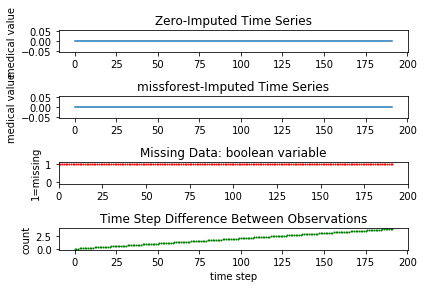

variable:  1


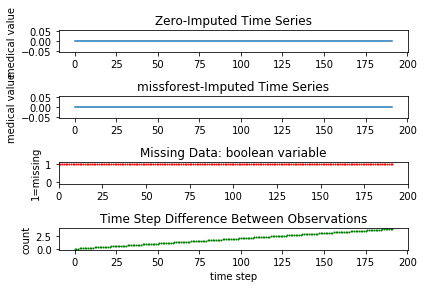

variable:  2


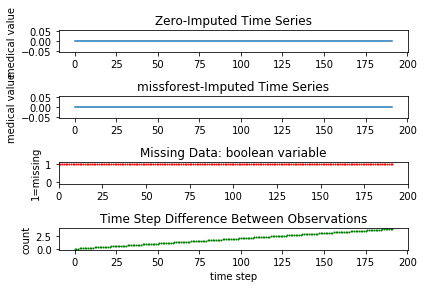

variable:  3


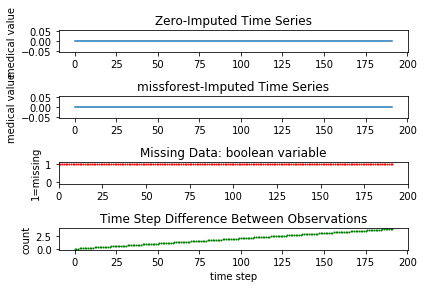

variable:  4


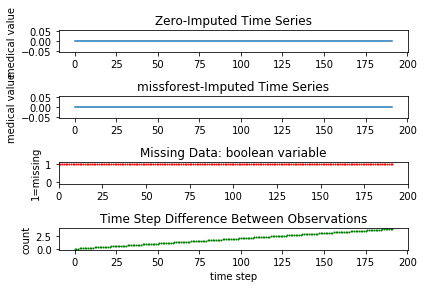

variable:  5


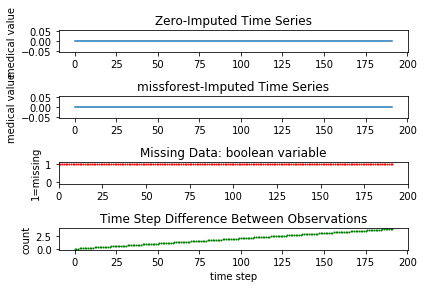

variable:  6


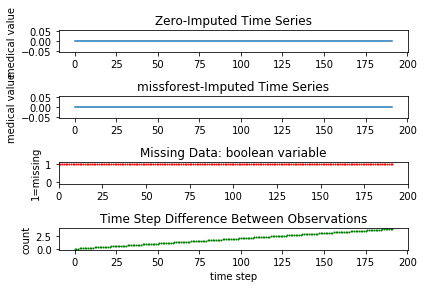

variable:  7


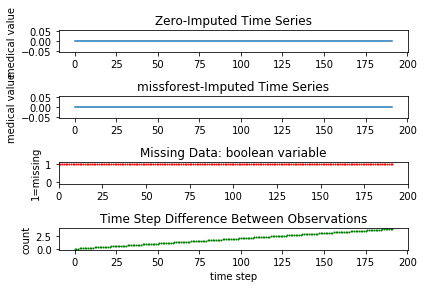

variable:  8


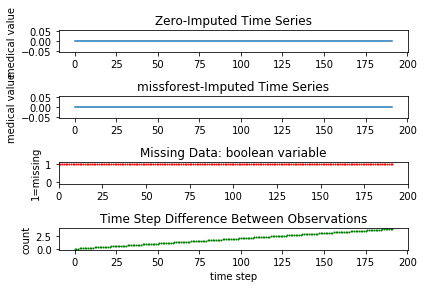

variable:  9


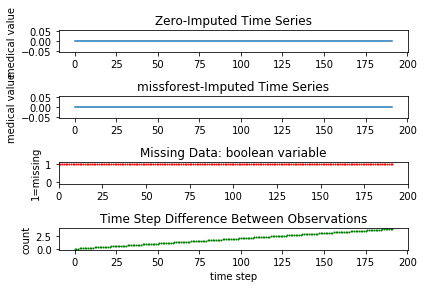

variable:  10


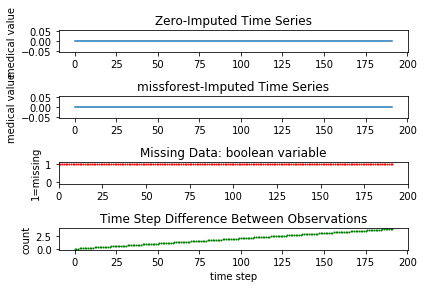

variable:  11


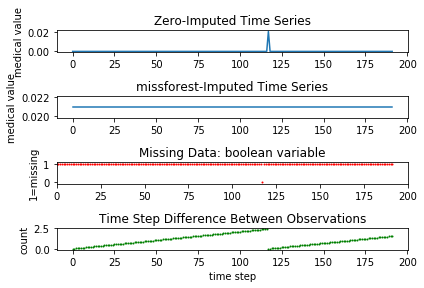

variable:  12


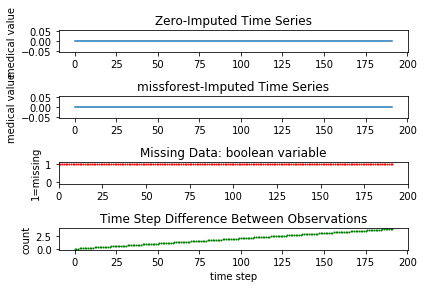

variable:  13


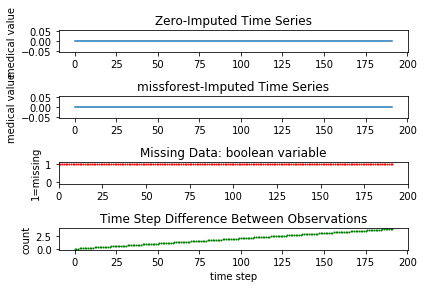

variable:  14


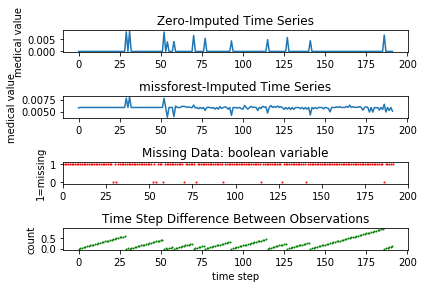

variable:  15


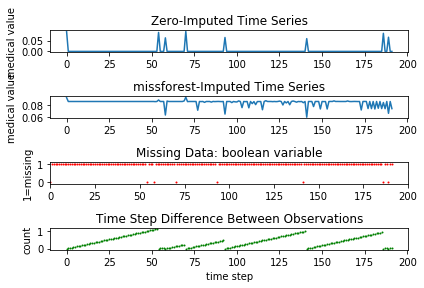

variable:  16


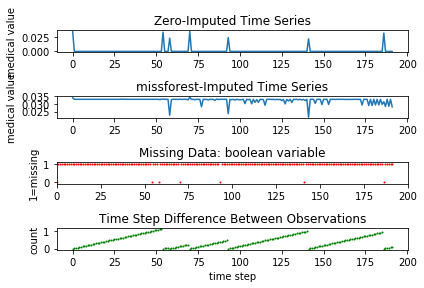

variable:  17


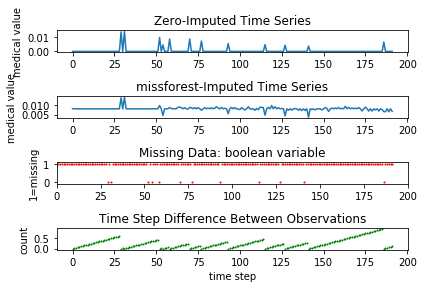

variable:  18


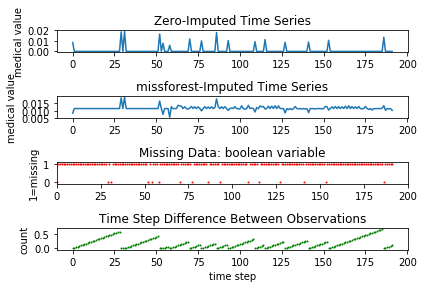

variable:  19


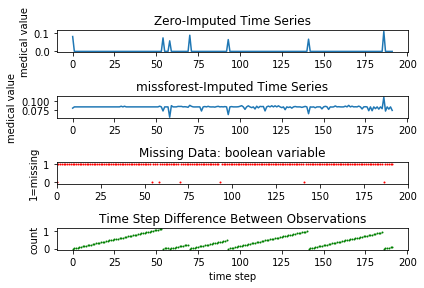

variable:  20


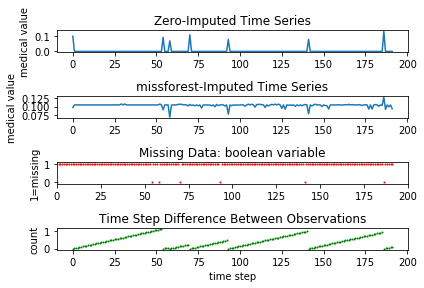

variable:  21


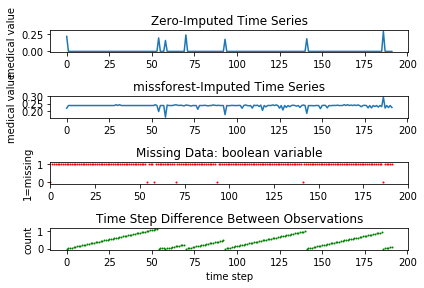

variable:  22


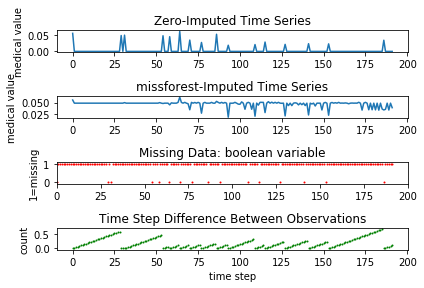

variable:  23


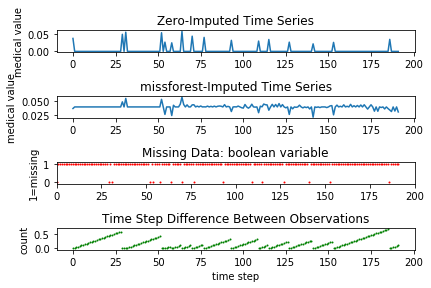

variable:  24


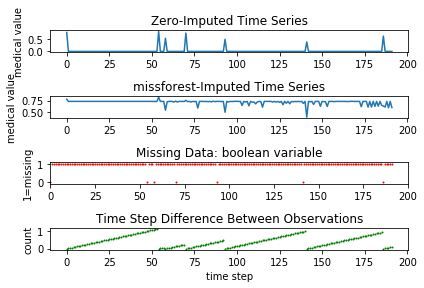

variable:  25


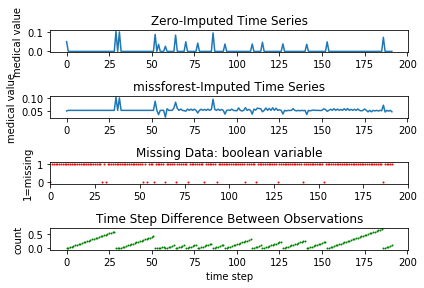

variable:  26


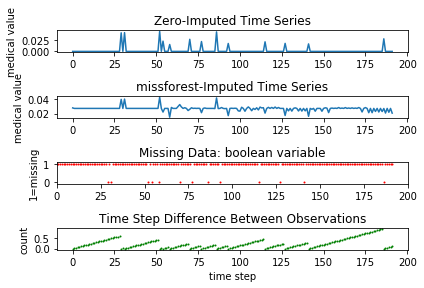

variable:  27


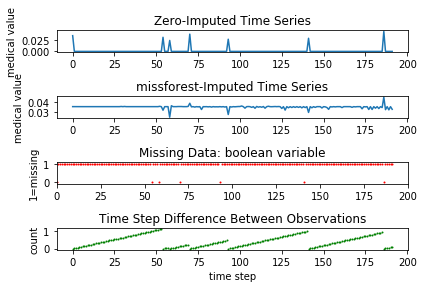

variable:  28


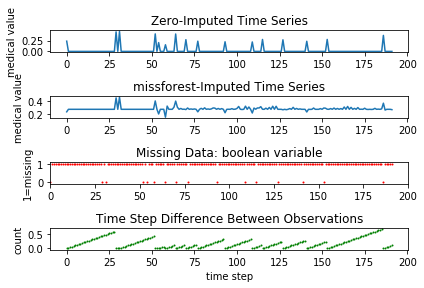

variable:  29


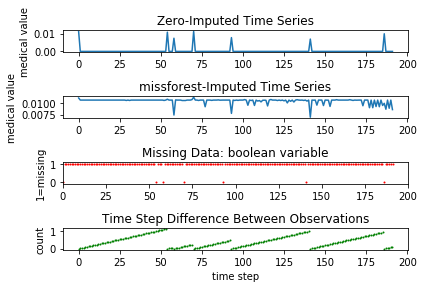

variable:  30


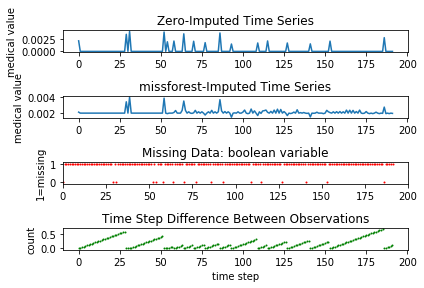

variable:  31


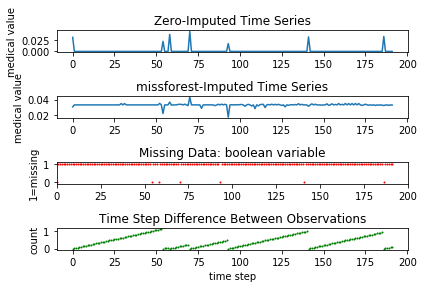

variable:  32


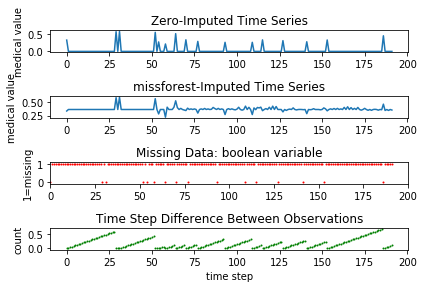

variable:  33


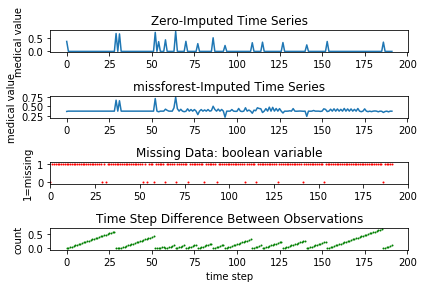

variable:  34


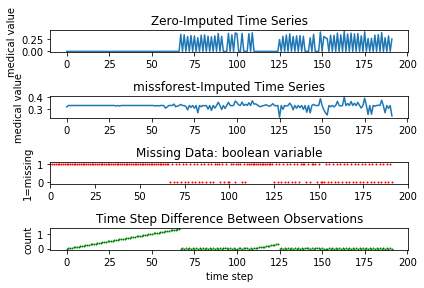

variable:  35


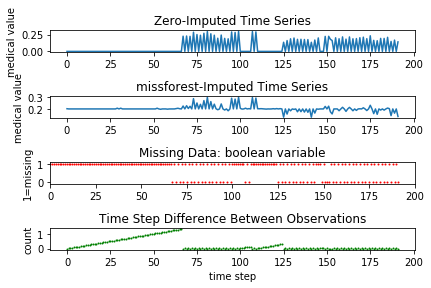

variable:  36


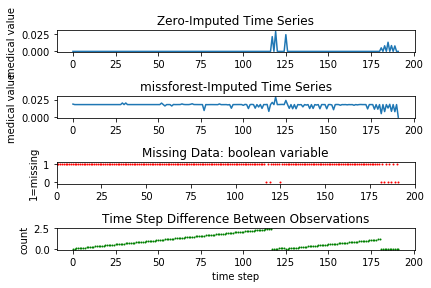

variable:  37


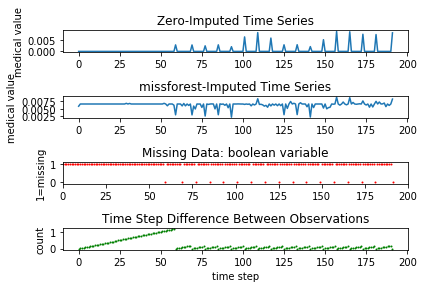

variable:  38


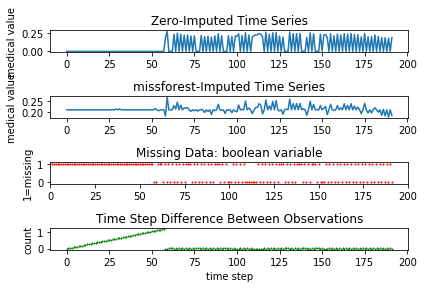

variable:  39


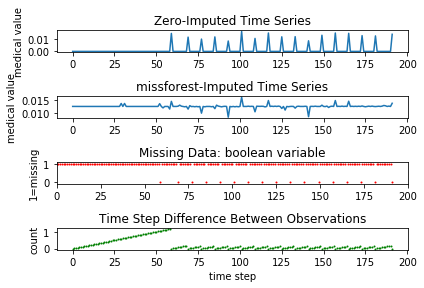

variable:  40


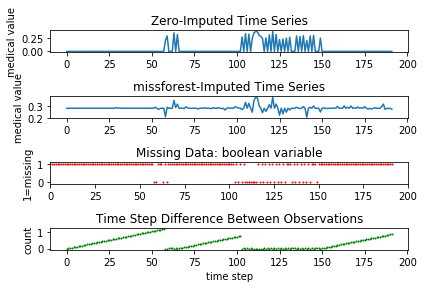

variable:  41


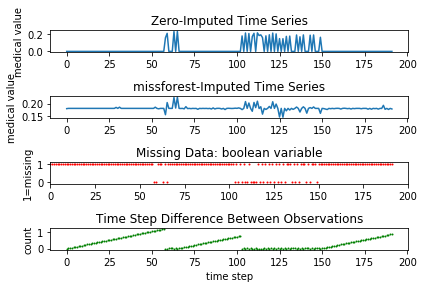

variable:  42


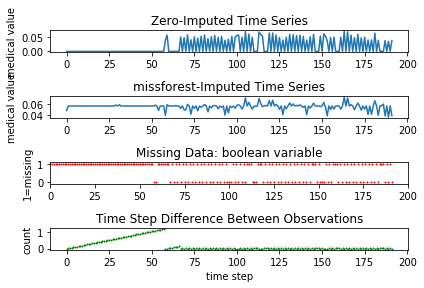

variable:  43


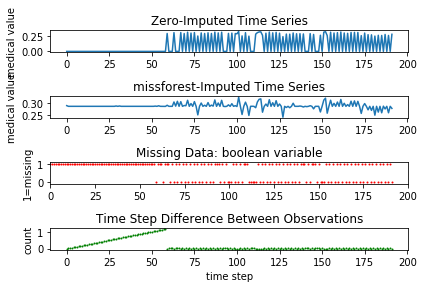

variable:  44


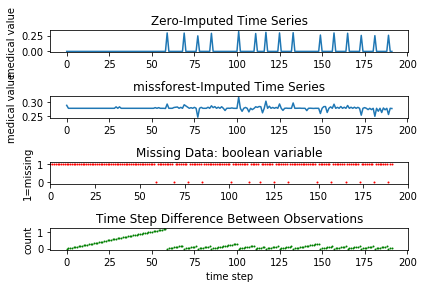

variable:  45


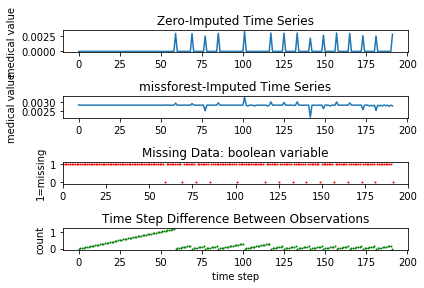

variable:  46


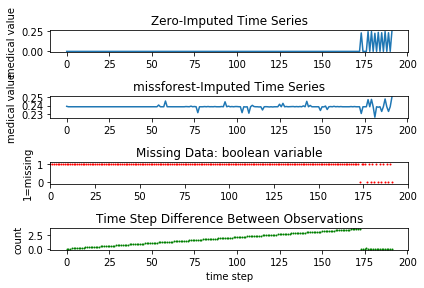

variable:  47


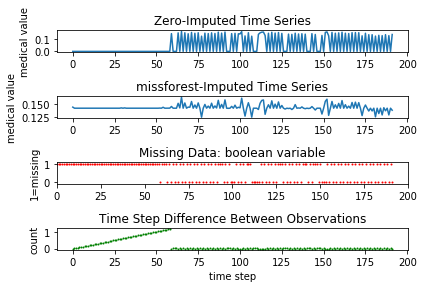

variable:  48


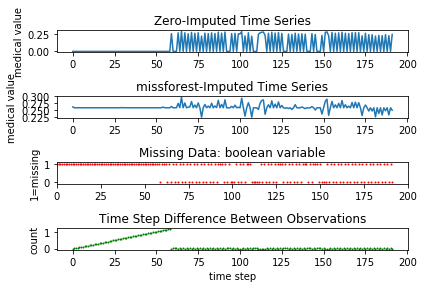

variable:  49


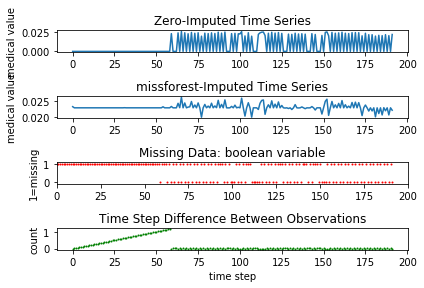

variable:  50


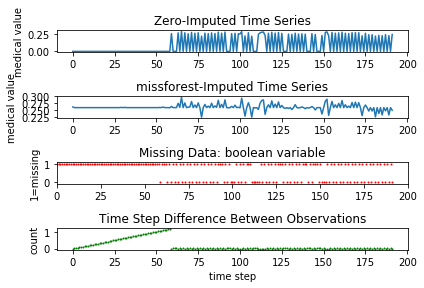

variable:  51


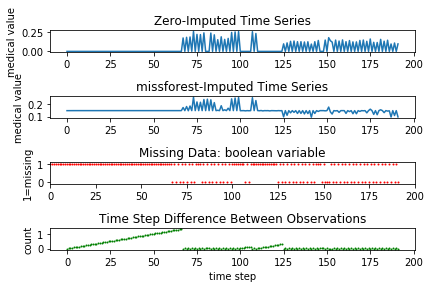

variable:  52


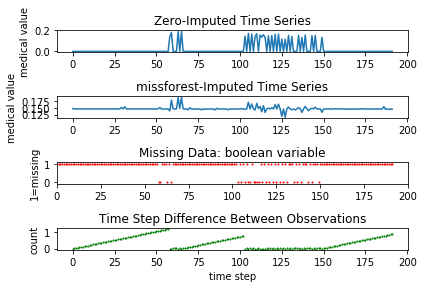

variable:  53


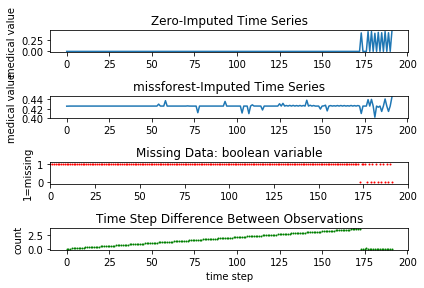

variable:  54


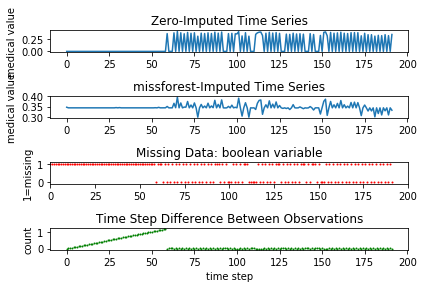

variable:  55


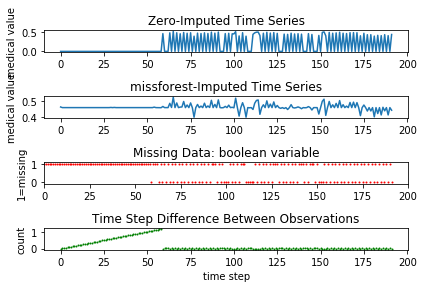

variable:  56


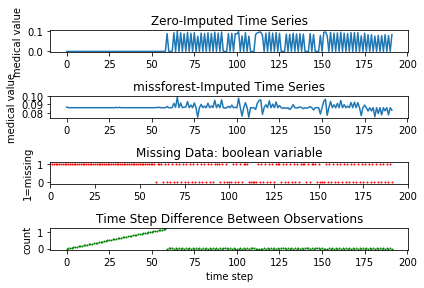

variable:  57


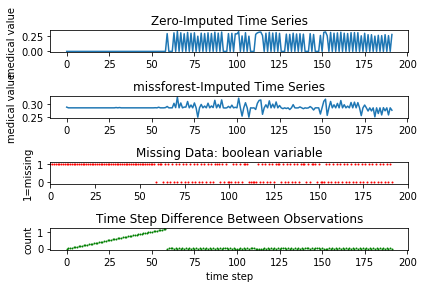

variable:  58


IndexError: index 58 is out of bounds for dimension 1 with size 58

In [21]:
plotMissForestImputation(1, out1, out2, out3)

#timeseries for variables [0,11) union with (11,13] were imputed with zeros b/c there were too few patient observations
#time sereis for variable 11 was imputed using given imputation method b/c there was an observation